# Exploração da base de dados anotada manualmente do tipo de requerente

In [1]:
import pandas as pd

arquivo = "..//3_2_Anotacao_manual//Datasets_anotados_manual_final//Recorrente_anotado_manual.csv"
df = pd.read_csv( arquivo, encoding='utf-8' )
print( df.info() )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   RECORRENTE  538 non-null    object
 1   TRIBUNAL    538 non-null    object
 2   ROTULO      538 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 12.7+ KB
None


### Conferindo datasets carregados

In [2]:
#aumenta o tamanho de exibição para poder ler o texto do dispositivo do acórdão
pd.set_option('display.max_colwidth', 300)

In [3]:
df.sample(3, random_state=1)

,RECORRENTE,TRIBUNAL,ROTULO
159,RODRIGO DIAZ,TRT4,1
397,DANIEL PINHEIRO,TRT3,1
323,GILSON COSTA RIBEIRO,TRT3,1


### Removendo linhas sem label anotado

In [4]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 538 entries, 0 to 537
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   RECORRENTE  538 non-null    object
 1   TRIBUNAL    538 non-null    object
 2   ROTULO      538 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 16.8+ KB


In [5]:
#limpeza de caracteres em branco
df["RECORRENTE"] = df["RECORRENTE"].astype(str).map(str.strip)

In [6]:
df_tudo = df
df_tudo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 538 entries, 0 to 537
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   RECORRENTE  538 non-null    object
 1   TRIBUNAL    538 non-null    object
 2   ROTULO      538 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 16.8+ KB


## Labels nos datasets

1 - RECLAMANTE = EMPREGADO <BR>
0 - RECLAMADO = EMPRESA

In [8]:
df_tudo.ROTULO.unique()

array([1, 0])

## Balanceamento das classes

In [9]:
df_tudo["ROTULO"].value_counts()

1    312
0    226
Name: ROTULO, dtype: int64

<AxesSubplot:>

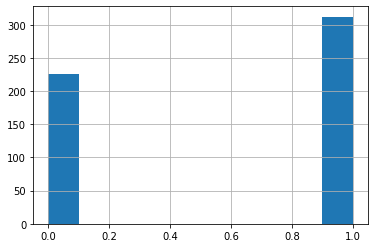

In [10]:
df_tudo["ROTULO"].hist()

### Contagens de palavras

In [11]:
df_tudo['RECORRENTE_CARACTERES'] = df_tudo['RECORRENTE'].astype(str).apply(len)
df_tudo['RECORRENTE_PALAVRAS'] = df_tudo['RECORRENTE'].apply(lambda x: len(str(x).split()))

In [12]:
df_tudo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 538 entries, 0 to 537
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   RECORRENTE             538 non-null    object
 1   TRIBUNAL               538 non-null    object
 2   ROTULO                 538 non-null    int64 
 3   RECORRENTE_CARACTERES  538 non-null    int64 
 4   RECORRENTE_PALAVRAS    538 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 25.2+ KB


## Analise das variáveis

In [14]:
import plotly.graph_objects as go
from plotly.offline import iplot

x_TRT3 = df_tudo[df_tudo["TRIBUNAL"] == "TRT3"]["ROTULO"]
x_TRT4 = df_tudo[df_tudo["TRIBUNAL"] == "TRT4"]["ROTULO"]

fig = go.Figure( )

fig.add_trace(go.Histogram(
    x=x_TRT3,
    name="TRT 3ª Região",
    marker_color='#EB89B5' ))
fig.add_trace(go.Histogram(
    x=x_TRT4,
    name="TRT 4ª Região",
    marker_color='#330C73' ))

# Overlay both histograms
fig.update_layout(
    title='Histograma quantidade de instâncias em cada classe anotada por tribunal',
    #xaxis_title_text='Label anotado',
    yaxis_title_text='Quantidade',
    bargap=0.2,
    bargroupgap=0.1
    )
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

## Distribuição dos unigramas mais usadas depois de remover stop words

In [16]:
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um']

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer( stop_words = frozenset( stopwords ) ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df_tudo['RECORRENTE'], 30)
df2 = pd.DataFrame(common_words, columns = ['RECORRENTE' , 'QUANTIDADE'])
df2

,RECORRENTE,QUANTIDADE
0,ltda,78
1,silva,40
2,santos,26
3,rodrigues,20
4,brasil,20
5,sa,19
6,oliveira,18
7,estado,17
8,pereira,16
9,sul,15


In [20]:
trace = go.Bar(x=df2["RECORRENTE"], y=df2["QUANTIDADE"])
iplot({"data":[trace]})

## Distribuição dos bigramas mais usadas depois de remover stop words

In [21]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer( stop_words = frozenset( stopwords ), ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df_tudo['RECORRENTE'], 30)
df4 = pd.DataFrame(common_words, columns = ['RECORRENTE' , 'QUANTIDADE'])
df4

,RECORRENTE,QUANTIDADE
0,rio grande,12
1,grande sul,12
2,minas gerais,11
3,brasil ltda,8
4,estado rio,8
5,caixa economica,7
6,economica federal,7
7,empresa brasileira,6
8,via varejo,6
9,estado minas,6


In [22]:
trace = go.Bar(x=df4["RECORRENTE"], y=df4["QUANTIDADE"])
iplot({"data":[trace]})

## Distribuição dos trigramas mais usadas depois de remover stop words

In [23]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer( stop_words = frozenset( stopwords ), ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df_tudo['RECORRENTE'], 20)
df6 = pd.DataFrame(common_words, columns = ['RECORRENTE' , 'QUANTIDADE'])
df6

,RECORRENTE,QUANTIDADE
0,rio grande sul,12
1,estado rio grande,8
2,caixa economica federal,7
3,mgs minas gerais,6
4,estado minas gerais,5
5,fca fiat chrysler,5
6,minas gerais administracao,4
7,gerais administracao servicos,4
8,randon sa implementos,3
9,sa implementos participacoes,3


In [24]:
trace = go.Bar(x=df6["RECORRENTE"], y=df6["QUANTIDADE"])
iplot({"data":[trace]})

## Distribuição dos unigramas mais usadas depois de remover stop words em relação a cada classe anotada

In [25]:
RECLAMANTE = 1
RECLAMADA = 0

### Classe: RECLAMANTE

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer( stop_words = frozenset( stopwords ) ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words( df_tudo.loc[ df_tudo["ROTULO"] == RECLAMANTE,'RECORRENTE' ], 20)
df1 = pd.DataFrame(common_words, columns = ['RECORRENTE' , 'QUANTIDADE'])
print( df1 )

trace = go.Bar(x=df1["RECORRENTE"], y=df1["QUANTIDADE"])
iplot({"data":[trace]})

   RECORRENTE  QUANTIDADE
0       silva          38
1      santos          26
2   rodrigues          19
3    oliveira          16
4     pereira          14
5    ferreira          13
6        jose          13
7      carlos          13
8       souza          13
9       maria          12
10    antonio          11
11      costa           9
12      alves           9
13      rocha           8
14     soares           7
15       rosa           7
16       luis           7
17    almeida           7
18       luiz           6
19   henrique           6


### Classe: RECLAMADA

In [28]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer( stop_words = frozenset( stopwords ) ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words( df_tudo.loc[ df_tudo["ROTULO"] == RECLAMADA,'RECORRENTE' ], 30)
df2 = pd.DataFrame(common_words, columns = ['RECORRENTE' , 'QUANTIDADE'])
print( df2 )

trace = go.Bar(x=df2["RECORRENTE"], y=df2["QUANTIDADE"])
iplot({"data":[trace]})

       RECORRENTE  QUANTIDADE
0            ltda          73
1          brasil          20
2              sa          19
3          estado          17
4             sul          15
5           minas          15
6             rio          14
7          grande          12
8       municipio          12
9          gerais          12
10       fundacao          11
11        federal          10
12          banco           9
13       comercio           8
14    transportes           8
15        empresa           7
16       servicos           7
17            via           7
18           vale           7
19          caixa           7
20      economica           7
21    implementos           6
22      companhia           6
23      sindicato           6
24     brasileira           6
25         varejo           6
26            mgs           6
27  supermercados           5
28    rodoviarios           5
29   distribuicao           5


## Distribuição dos bigramas mais usadas depois de remover stop words em relação a cada classe anotada

### Classe: RECLAMANTE

In [29]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer( stop_words = frozenset( stopwords ), ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram( df_tudo.loc[ df_tudo["ROTULO"] == RECLAMANTE,'RECORRENTE' ], 30)
df4 = pd.DataFrame(common_words, columns = ['RECORRENTE' , 'QUANTIDADE'])
print(df4)

trace = go.Bar(x=df4["RECORRENTE"], y=df4["QUANTIDADE"])
iplot({"data":[trace]})

            RECORRENTE  QUANTIDADE
0       antonio carlos           3
1   henrique rodrigues           2
2        pereira silva           2
3      soares oliveira           2
4          reis junior           2
5          rocha silva           2
6        alves barbosa           2
7           maria jose           2
8      marcos vinicius           2
9       pereira santos           2
10   antonio conceicao           1
11     conceicao silva           1
12        braz ricardo           1
13     ricardo sampaio           1
14     sampaio correia           1
15        vagner brito           1
16       brito andrade           1
17     alex nascimento           1
18    cristiano soares           1
19       soares santos           1
20         juarez luiz           1
21         luiz tibola           1
22    regina itanajara           1
23      itanajara rosa           1
24         rosa santos           1
25       gregory preto           1
26     preto capaverde           1
27        jacson cou

### Classe: RECLAMADA

In [30]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer( stop_words = frozenset( stopwords ), ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram( df_tudo.loc[ df_tudo["ROTULO"] == RECLAMADA,'RECORRENTE' ], 30)
df4 = pd.DataFrame(common_words, columns = ['RECORRENTE' , 'QUANTIDADE'])
print(df4)

trace = go.Bar(x=df4["RECORRENTE"], y=df4["QUANTIDADE"])
iplot({"data":[trace]})

                   RECORRENTE  QUANTIDADE
0                  rio grande          12
1                  grande sul          12
2                minas gerais          11
3                 brasil ltda           8
4                  estado rio           8
5             caixa economica           7
6           economica federal           7
7          empresa brasileira           6
8                  via varejo           6
9                estado minas           6
10                  mgs minas           6
11              itau unibanco           5
12                   fca fiat           5
13              fiat chrysler           5
14              comercio ltda           4
15       gerais administracao           4
16     administracao servicos           4
17             banco bradesco           4
18                  randon sa           3
19             sa implementos           3
20  implementos participacoes           3
21          wms supermercados           3
22       supermercados brasil     

## Distribuição dos trigramas mais usadas antes de remover stop words em relação a cada classe anotada

### Classe: RECLAMANTE

In [31]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer( stop_words = frozenset( stopwords ), ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram( df_tudo.loc[ df_tudo["ROTULO"] == RECLAMANTE,'RECORRENTE' ], 20)
df6 = pd.DataFrame(common_words, columns = ['RECORRENTE' , 'QUANTIDADE'])
print( df6 )

trace = go.Bar(x=df6["RECORRENTE"], y=df6["QUANTIDADE"])
iplot({"data":[trace]})


                   RECORRENTE  QUANTIDADE
0     antonio conceicao silva           1
1        braz ricardo sampaio           1
2     ricardo sampaio correia           1
3        vagner brito andrade           1
4     cristiano soares santos           1
5          juarez luiz tibola           1
6       regina itanajara rosa           1
7       itanajara rosa santos           1
8     gregory preto capaverde           1
9           jacson couto rosa           1
10   henrique rodrigues sousa           1
11      rodrigues sousa costa           1
12    rafael pinto figueiredo           1
13   vinicius jornada machado           1
14      deise teresinha silva           1
15     teresinha silva correa           1
16   claudemir alves figueiro           1
17       artur tume cremonese           1
18  karina fagundes rodrigues           1
19      andresa gehlen felini           1


### Classe: RECLAMADA

In [32]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer( stop_words = frozenset( stopwords ), ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram( df_tudo.loc[ df_tudo["ROTULO"] == RECLAMADA,'RECORRENTE' ], 20)
df6 = pd.DataFrame(common_words, columns = ['RECORRENTE' , 'QUANTIDADE'])
print( df6 )

trace = go.Bar(x=df6["RECORRENTE"], y=df6["QUANTIDADE"])
iplot({"data":[trace]})


                        RECORRENTE  QUANTIDADE
0                   rio grande sul          12
1                estado rio grande           8
2          caixa economica federal           7
3                 mgs minas gerais           6
4              estado minas gerais           5
5                fca fiat chrysler           5
6       minas gerais administracao           4
7    gerais administracao servicos           4
8            randon sa implementos           3
9     sa implementos participacoes           3
10        wms supermercados brasil           3
11       supermercados brasil ltda           3
12  guerra implementos rodoviarios           3
13                banco estado rio           3
14                   grande sul sa           3
15        fiat chrysler automoveis           3
16      chrysler automoveis brasil           3
17          automoveis brasil ltda           3
18      fundacao protecao especial           2
19           protecao especial rio           2


## Distribuição da quantidade de palavras pela classes anotadas

In [33]:
df_tudo.groupby(["ROTULO", "TRIBUNAL"])["RECORRENTE_PALAVRAS"].describe()

count      mean       std  min  25%  50%  75%   max
ROTULO TRIBUNAL                                                     
0      TRT3      136.0  5.713235  2.841252  2.0  3.0  5.0  7.0  20.0
       TRT4       90.0  5.788889  2.483629  2.0  4.0  5.0  7.0  13.0
1      TRT3      133.0  3.894737  1.136603  2.0  3.0  4.0  4.0  10.0
       TRT4      179.0  3.553073  1.017393  2.0  3.0  3.0  4.0   9.0

In [ ]:
#df_tudo.groupby(["ROTULO", "TRIBUNAL"])["DISPOSITIVO_CARACTERES", "DISPOSITIVO_PALAVRAS"].describe().to_csv( "dataset_anotado_describe_com_indice.csv", encoding='utf-8' )

# Termos característicos e suas associações
#### Tokenizador de palavras da lingua portuguesa e preparação do corpus no Scattertext

In [34]:
#conda install -c conda-forge scattertext
#conda install -c conda-forge spacy
#python -m spacy download pt_core_news_sm

import scattertext as st
import spacy
from spacy.tokens import Doc
from nltk.tokenize import RegexpTokenizer

def tokenize(text):
    """
    Tokenize the given sentence in Portuguese.
    :param text: text to be tokenized, as a string
    """
    tokenizer_regexp = r'''(?ux)
    # the order of the patterns is important!!
    # more structured patterns come first
    [a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+(?:\.[a-zA-Z0-9-]+)+|    # emails
    (?:https?://)?\w{2,}(?:\.\w{2,})+(?:/\w+)*|                  # URLs
    (?:[\#@]\w+)|                     # Hashtags and twitter user names
    (?:[^\W\d_]\.)+|                  # one letter abbreviations, e.g. E.U.A.
    (?:[DSds][Rr][Aa]?)\.|            # common abbreviations such as dr., sr., sra., dra.
    (?:\B-)?\d+(?:[:.,]\d+)*(?:-?\w)*|
        # numbers in format 999.999.999,999, possibly followed by hyphen and alphanumerics
        # \B- avoids picks as F-14 as a negative number
    \.{3,}|                           # ellipsis or sequences of dots
    \w+|                              # alphanumerics
    -+|                               # any sequence of dashes
    \S                                # any non-space character
    '''
    tokenizer = RegexpTokenizer(tokenizer_regexp)

    return tokenizer.tokenize(text)

class PortugueseTokenizer(object):
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        words = tokenize( text )
        # All tokens 'own' a subsequent space character in this tokenizer
        spaces = [True] * len(words)
        return Doc(self.vocab, words=words, spaces=spaces)

nlp = spacy.load("pt_core_news_sm")
nlp.tokenizer = PortugueseTokenizer(nlp.vocab)

corpus = st.CorpusFromPandas(df_tudo, category_col='ROTULO', text_col='RECORRENTE', nlp=nlp).build()

# Principais termos e suas associações para ambos os tribunais
## Palavras que diferenciam o corpus de acórdãos de um corpus comum da língua portuguesa

In [35]:
print(list(corpus.get_scaled_f_scores_vs_background().index[:10]))

['implementos', 'varejo', 'supermercados', 'rodoviarios', 'distribuicao', 'itau', 'terezinha', 'administracao', 'aparecido', 'aeroportuaria']


## Termos mais associados com os acórdãos anotados como RECLAMANTE

In [37]:
import pprint

term_freq_df = corpus.get_term_freq_df()
term_freq_df['RECLAMANTE Score'] = corpus.get_scaled_f_scores(RECLAMANTE)
term_freq_df.sort_values(by='RECLAMANTE Score', ascending=False).index[:10]
pprint.pprint( list( term_freq_df.sort_values(by='RECLAMANTE Score', ascending=False).index[:10] ) )

['da silva',
 'santos',
 'dos santos',
 'ferreira',
 'de souza',
 'alves',
 'rocha',
 'luis',
 'rosa',
 'almeida']


## Termos mais associados com os acórdãos anotados como RECLAMADA

In [38]:
import pprint

term_freq_df = corpus.get_term_freq_df()
term_freq_df['RECLAMADA Score'] = corpus.get_scaled_f_scores(RECLAMADA)
term_freq_df.sort_values(by='RECLAMADA Score', ascending=False).index[:10]
pprint.pprint( list( term_freq_df.sort_values(by='RECLAMADA Score', ascending=False).index[:10] ) )

['a', 'e', 's', 's.a.', 'brasil', 'sa', 'estado', 'minas', 'sul', 'do rio']


## Visualização dos termos e suas associações

In [ ]:
html = st.produce_scattertext_explorer(corpus,
          category='DEFERIMENTO',
          category_name='DEFERIMENTO',
          not_category_name='INDEFERIMENTO',
          width_in_pixels=1000,
          metadata=df_tudo['DISPOSITIVO'])
open("Convention-Visualization.html", 'wb').write(html.encode('utf-8'))

In [47]:
html = st.produce_scattertext_explorer(corpus,
          category='RECLAMANTE',
          category_name='RECLAMANTE',
          not_category_name='RECLAMADA',
          width_in_pixels=1000,
          metadata=df_tudo['RECORRENTE'])
open("TIPO_RECORRENTE_Convention-Visualization.html", 'wb').write(html.encode('utf-8'))

AssertionError: 